paket installieren:

Terminal > New Terminal

venv aktivieren:
```
.\.venv\Scripts\activate
```

paket installieren:

```
pip install pandas
``` 

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math


In [ ]:
# file paths
path_motors_none_rounded_imu = "c:/Users/charl/Desktop/Uni_Leipzig/MA/Code/PlatformIO/IMU_Audit/MA_files/Recherche/Ergebnisse/Motors_None_Rounded/2025-01-22_17-03-38.sensors.dat"
path_motors_none_rounded_cam = "c:/Users/charl/Desktop/Uni_Leipzig/MA/Code/PlatformIO/IMU_Audit/MA_files/Recherche/Ergebnisse/Motors_None_Rounded/2025-01-22_17-03-38.dat"
path_imu_integral_rounded_imu = "c:/Users/charl/Desktop/Uni_Leipzig/MA/Code/PlatformIO/IMU_Audit/MA_files/Recherche/Ergebnisse/IMU_Integral_Rounded/2025-01-22_16-54-27.sensors.dat"
path_imu_integral_rounded_cam = "c:/Users/charl/Desktop/Uni_Leipzig/MA/Code/PlatformIO/IMU_Audit/MA_files/Recherche/Ergebnisse/IMU_Integral_Rounded/2025-01-22_16-54-27.dat"
path_imu_madgwick_rounded_imu = "c:/Users/charl/Desktop/Uni_Leipzig/MA/Code/PlatformIO/IMU_Audit/MA_files/Recherche/Ergebnisse/IMU_Madgwick_Rounded/2025-01-22_15-06-50.sensors.dat"
path_imu_madgwick_rounded_cam = "c:/Users/charl/Desktop/Uni_Leipzig/MA/Code/PlatformIO/IMU_Audit/MA_files/Recherche/Ergebnisse/IMU_Madgwick_Rounded/2025-01-22_15-06-50.dat"
path_imu_madgwick_square_imu = "c:/Users/charl/Desktop/Uni_Leipzig/MA/Code/PlatformIO/IMU_Audit/MA_files/Recherche/Ergebnisse/IMU_Madgwick_Square/2025-01-22_16-03-09.sensors.dat"
path_imu_madgwick_square_cam = "c:/Users/charl/Desktop/Uni_Leipzig/MA/Code/PlatformIO/IMU_Audit/MA_files/Recherche/Ergebnisse/IMU_Madgwick_Square/2025-01-22_16-03-09.dat"

# header für imu daten
column_names_motors = ["frame", "start_stopp", "empty0", "empty1", "empty2", "empty3", "empty4"]
column_names_madgwick = ["frame", "start_stopp", "angle", "o_w", "o_x", "o_y", "o_z"]
column_names_integral = ["frame", "start_stopp", "angle", "NaN", "gyro_x", "gyro_y", "gyro_z"]

# dateien einlesen in pd dataframes
df_path_motors_none_rounded_imu = pd.read_csv(path_motors_none_rounded_imu, sep=' ', header=None, names=column_names_motors)
df_path_motors_none_rounded_cam = pd.read_csv(path_motors_none_rounded_cam, sep=' ', header=0)
df_path_imu_integral_rounded_imu = pd.read_csv(path_imu_integral_rounded_imu, sep=' ', header=None, names=column_names_integral)
df_path_imu_integral_rounded_cam = pd.read_csv(path_imu_integral_rounded_cam, sep=' ', header=0)
df_path_imu_madgwick_rounded_imu = pd.read_csv(path_imu_madgwick_rounded_imu, sep=' ', header=None, names=column_names_madgwick)
df_path_imu_madgwick_rounded_cam = pd.read_csv(path_imu_madgwick_rounded_cam, sep=' ', header=0)
df_path_imu_madgwick_square_imu = pd.read_csv(path_imu_madgwick_square_imu, sep=' ', header=None, names=column_names_madgwick)
df_path_imu_madgwick_square_cam = pd.read_csv(path_imu_madgwick_square_cam, sep=' ', header=0)


In [150]:
# print("df_path_motors_none_rounded_imu:")
# print(df_path_motors_none_rounded_imu.head())
# print("df_path_motors_none_rounded_cam:")
# print(df_path_motors_none_rounded_cam.head())
# print("df_path_imu_integral_rounded_imu:")
# print(df_path_imu_integral_rounded_imu.head())
# print("df_path_imu_integral_rounded_cam:")
# print(df_path_imu_integral_rounded_cam.head())
# print("df_path_imu_madgwick_rounded_imu:")
# print(df_path_imu_madgwick_rounded_imu.head())
# print("df_path_imu_madgwick_rounded_cam:")
# print(df_path_imu_madgwick_rounded_cam.head())
# print("df_path_imu_madgwick_square_imu:")
# print(df_path_imu_madgwick_square_imu.head())
# print("df_path_imu_madgwick_square_cam:")
# print(df_path_imu_madgwick_square_cam.head())

In [151]:
def cyclic_mean(series, period=2 * np.pi):
    """
    Berechnet den Mittelwert einer zyklischen Serie, z. B. für Winkel oder Uhrzeiten.

    Args:
        series (pd.Series): Die Serie mit zyklischen Werten.
        period (float): Der Zyklus der Werte (z. B. 2π für Winkel, 24 für Uhrzeiten).
    
    Returns:
        float: Der zyklische Mittelwert.
    """
    # Umwandlung der Werte in Radien (wenn nicht bereits im passenden Bereich)
    radians = series * (2 * np.pi / period)  # Normierung auf [0, 2π]
    
    # Umrechnung in kartesische Koordinaten
    x = np.cos(radians)
    y = np.sin(radians)
    
    # Durchschnitt der kartesischen Koordinaten berechnen
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    
    # Zurück in zyklischen Winkel umrechnen
    mean_angle = np.arctan2(mean_y, mean_x)
    
    # Ergebnis auf den ursprünglichen Zyklus zurückskalieren
    cyclic_mean_value = (mean_angle % (2 * np.pi)) * (period / (2 * np.pi))
    
    return cyclic_mean_value


In [152]:
def cyclic_difference(value1, value2, period=2 * np.pi):
    """
    Berechnet die zyklische Differenz zwischen zwei Werten.

    Args:
        value1 (float): Erster Wert.
        value2 (float): Zweiter Wert.
        period (float): Der Zyklus der Werte (Standard: 2π).
    
    Returns:
        float: Die zyklische Differenz im Bereich [-period/2, period/2].
    """
    # Berechne die rohe Differenz
    raw_diff = value1 - value2
    
    # Bringe die Differenz in den Bereich [-period/2, period/2]
    cyclic_diff = (raw_diff + period / 2) % period - period / 2
    
    return cyclic_diff

In [153]:
results = []

# für Motors_None_Rounded (avg_angle_diff: 1.5197440654558285)
df_imu = df_path_motors_none_rounded_imu
df_cam = df_path_motors_none_rounded_cam

# für IMU_Integral_Rounded (avg_angle_diff: 1.4782854744422966)
# df_imu = df_path_imu_integral_rounded_imu
# df_cam = df_path_imu_integral_rounded_cam

# für IMU_Madgwick_Rounded (avg_angle_diff: 1.3997784776570412)
# df_imu = df_path_imu_madgwick_rounded_imu
# df_cam = df_path_imu_madgwick_rounded_cam

# für IMU_Madgwick_Square (avg_angle_diff: 1.4912999356180014)
# df_imu = df_path_imu_madgwick_square_imu
# df_cam = df_path_imu_madgwick_square_cam


# Iteration über jede Zeile von df_imu
for _, row in df_imu.iterrows():
    frame_value = row['frame']
    start_stopp = row['start_stopp']
    
    # Finde die Zeile in df_cam, die diesem frame entspricht
    df_cam_before_frame = df_cam[df_cam['frame'] < frame_value]
    
    # Berechne den Durchschnitt der letzten 20 Werte in der 'angle'-Spalte
    if len(df_cam_before_frame) >= 20:
        last_20_values = df_cam_before_frame['phi'].tail(20)
        avg_angle_last_20 = cyclic_mean(last_20_values, period=2 * np.pi)
    else:
        # Falls weniger als 20 Werte vorhanden sind, den Durchschnitt der verfügbaren berechnen
        avg_angle_last_20 = cyclic_mean(df_cam_before_frame['phi'], period=2 * np.pi)
    
    # Finde die Zeile in df_cam, die dem nächsten frame entspricht
    df_cam_after_frame = df_cam[df_cam['frame'] > frame_value]

    # Berechne den Durchschnitt der nächsten 20 Werte in der 'angle'-Spalte
    if len(df_cam_after_frame) >= 20:
        next_20_values = df_cam_after_frame['phi'].head(20)
        avg_angle_next_20 = cyclic_mean(next_20_values, period=2 * np.pi)
    else:
        # Falls weniger als 20 Werte vorhanden sind, den Durchschnitt der verfügbaren berechnen
        avg_angle_next_20 = cyclic_mean(df_cam_after_frame['phi'], period=2 * np.pi)
    
    # Füge das Ergebnis in das neue DataFrame hinzu
    results.append({'frame': frame_value, 'start_stopp': start_stopp, 'avg_angle_last_20': avg_angle_last_20, 'avg_angle_next_20': avg_angle_next_20})

# Konvertiere die Ergebnisse in ein DataFrame
result_df = pd.DataFrame(results)

result_df['angle_diff_prev'] = cyclic_difference(result_df['avg_angle_last_20'], result_df['avg_angle_next_20'].shift(1),period=2 * np.pi)

print(result_df)
print(cyclic_mean(result_df['angle_diff_prev'], period=2 * np.pi))
print(last_20_values)

    frame  start_stopp  avg_angle_last_20  avg_angle_next_20  angle_diff_prev
0     733            1           1.559141           1.623038              NaN
1     812            0           2.701154           3.019091         1.078116
2     937            1           3.064037           3.165706         0.044946
3    1015            0           4.228070           4.510374         1.062363
4    1140            1           4.537270           4.653537         0.026896
..    ...          ...                ...                ...              ...
87   9684            1           5.239521           5.333934        -0.046409
88   9763            0           0.135199           0.441453         1.084450
89   9888            1           0.391546           0.520549        -0.049907
90   9966            0           1.595107           1.921781         1.074558
91  10091            1           1.969215           2.068614         0.047434

[92 rows x 5 columns]
0.5591626668153413
9534    1.96559
9535  

# IMU Madgwick Square
0.23007097445754093

# IMU Madgwick Rounded
0.6052534384454791

# IMU Integral Rounded
0.5931432167263991

# Motors None Rounded
0.5591626668153413

In [154]:
# Neues DataFrame für die Ergebnisse
curves = []
curve_number = 1

# Iteration über result_df in Paaren
for i in range(len(result_df) - 1):
    if result_df.iloc[i]['start_stopp'] == 1 and result_df.iloc[i + 1]['start_stopp'] == 0:
        before_angle = result_df.iloc[i]['avg_angle_last_20']
        after_angle = result_df.iloc[i + 1]['avg_angle_next_20']
        angle_diff = cyclic_difference(after_angle, before_angle)

        # Prüfen, ob angle_diff > π und ggf. π abziehen
        # if angle_diff > math.pi:
        #     angle_diff -= 2*math.pi
        
        # Füge die Werte der aktuellen Kurve hinzu
        curves.append({
            'curve_number': curve_number,
            'before_angle': before_angle,
            'after_angle': after_angle,
            'angle_diff': angle_diff
        })
        curve_number += 1

# Konvertiere die Liste der Kurven in ein DataFrame
curves_df = pd.DataFrame(curves)

print(curves_df)

    curve_number  before_angle  after_angle  angle_diff
0              1      1.559141     3.019091    1.459950
1              2      3.064037     4.510374    1.446338
2              3      4.537270     6.011077    1.473807
3              4      6.005196     1.184555    1.462544
4              5      1.220963     2.749038    1.528075
5              6      2.810764     4.320604    1.509839
6              7      4.394672     5.914057    1.519384
7              8      5.983136     1.142852    1.442902
8              9      1.199655     2.728059    1.528404
9             10      2.792233     4.294090    1.501857
10            11      4.360984     5.911960    1.550977
11            12      5.991468     1.211890    1.503608
12            13      1.270607     2.778662    1.508055
13            14      2.847494     4.405042    1.557548
14            15      4.482837     6.002165    1.519328
15            16      6.028446     1.255772    1.510511
16            17      1.293881     2.794491    1

In [155]:
# durchschnitt für angle_diff aus curves_df berechnen
angle_diff_avg = curves_df['angle_diff'].mean()
angle_diff_std = curves_df['angle_diff'].std()
angle_diff_min = curves_df['angle_diff'].min()
angle_diff_max = curves_df['angle_diff'].max()
print("angle_diff_avg:", angle_diff_avg)
print("angle_diff_std:", angle_diff_std)
print("angle_diff_min:", angle_diff_min)
print("angle_diff_max:", angle_diff_max)

print((np.pi)/2)

angle_diff_avg: 1.4932659401555364
angle_diff_std: 0.04038877990428226
angle_diff_min: 1.3719839148770987
angle_diff_max: 1.5812122948826817
1.5707963267948966


# Motors_None_Rounded
pi/2: 1.5707963267948966 \
angle_diff_avg: 1.4932659401555364 \
angle_diff_std: 0.04038877990428226 \
angle_diff_min: 1.3719839148770987 \
angle_diff_max: 1.5812122948826817 

# IMU_Integral_Rounded
pi/2: 1.5707963267948966 \
angle_diff_avg: 1.5267675799468212 \
angle_diff_std: 0.03336129474065699 \
angle_diff_min: 1.4398230872512556 \
angle_diff_max: 1.5849497893218487 

# IMU_Madgwick_Square
pi/2: 1.5707963267948966 \
angle_diff_avg: 1.5697050276880908 \
angle_diff_std: 0.01710826117083013 \
angle_diff_min: 1.5461179065283241 \
angle_diff_max: 1.620963152947934 

# IMU_Madgwick_Rounded
pi/2: 1.5707963267948966 \
angle_diff_avg: 1.5625573048503079 \
angle_diff_std: 0.028269316840829187 \
angle_diff_min: 1.4774013953564875 \
angle_diff_max: 1.6253780882191933 

C:\Users\charl\AppData\Local\Temp\ipykernel_25404\2065452094.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


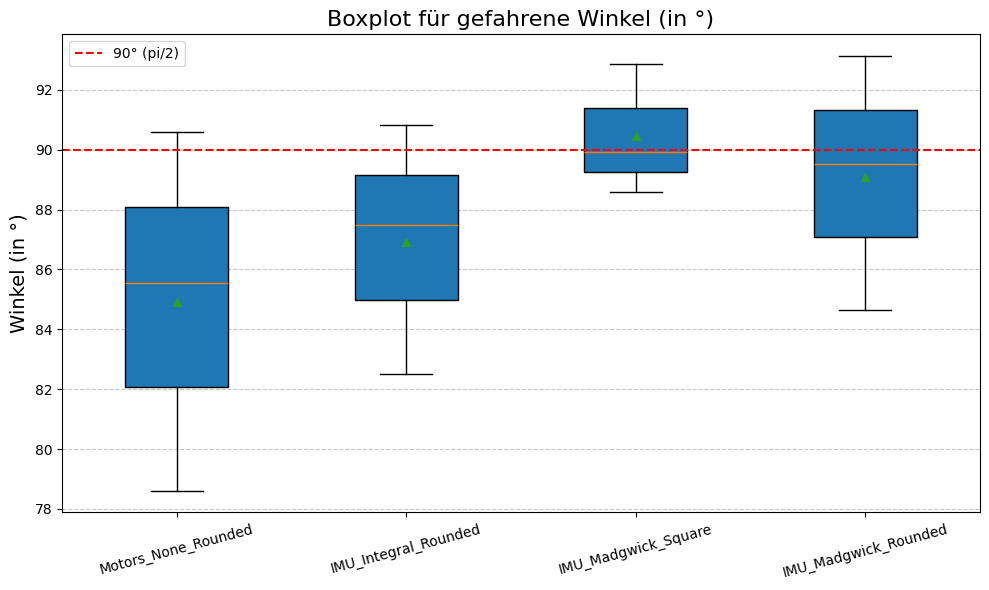

In [156]:
#import matplotlib.pyplot as plt

# Daten in Radiant
data = {
    "Motors_None_Rounded": [1.4932659401555364, 1.3719839148770987, 1.5812122948826817],
    "IMU_Integral_Rounded": [1.5267675799468212, 1.4398230872512556, 1.5849497893218487],
    "IMU_Madgwick_Square": [1.5697050276880908, 1.5461179065283241, 1.620963152947934],
    "IMU_Madgwick_Rounded": [1.5625573048503079, 1.4774013953564875, 1.6253780882191933],
}

# Daten von Radiant in Grad umrechnen
data_deg = {key: [np.degrees(value) for value in values] for key, values in data.items()}

# Boxplot erstellen
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(
    data_deg.values(), 
    vert=True, 
    patch_artist=True, 
    labels=data_deg.keys(), 
    showmeans=True
)

# Stil und Beschriftung
ax.set_title("Boxplot für gefahrene Winkel (in °)", fontsize=16)
ax.set_ylabel("Winkel (in °)", fontsize=14)
ax.axhline(y=np.degrees(1.5707963267948966), color='r', linestyle='--', label='90° (pi/2)')
ax.legend()

# Plot anzeigen
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [159]:
# daten für drift-analyse einlesen
path_drift = "c:/Users/charl/Desktop/Uni_Leipzig/MA/Code/PlatformIO/IMU_Audit/MA_files/Recherche/Ergebnisse/drift_log.txt"
df_drift = pd.read_csv(path_drift, sep=' ', header=0)
print(df_drift.head())


          x         y         z
0  0.080023 -0.050702 -0.014661
1  0.060781 -0.052840 -0.019853
2  0.026267 -0.043066 -0.019548
3  0.016188 -0.041539 -0.002749
4  0.042150 -0.042150 -0.038179


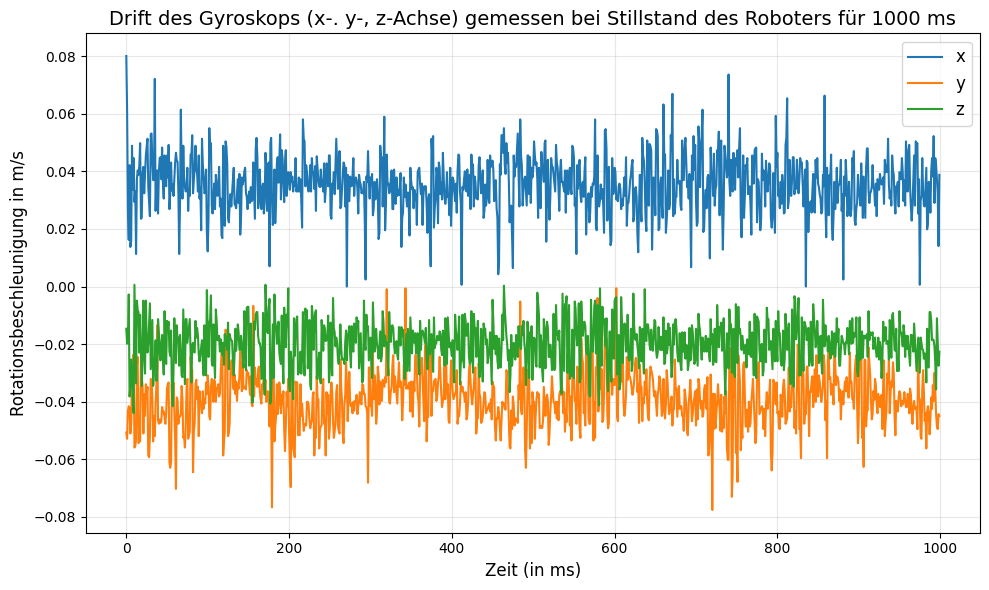

In [163]:
# Plot
plt.figure(figsize=(10, 6))

# Verlauf der Spalten plotten
# plt.plot(df_drift.index, df_drift["x"], label="x", marker="o")
# plt.plot(df_drift.index, df_drift["y"], label="y", marker="s")
# plt.plot(df_drift.index, df_drift["z"], label="z", marker="^")
plt.plot(df_drift.index, df_drift["x"], label="x")
plt.plot(df_drift.index, df_drift["y"], label="y")
plt.plot(df_drift.index, df_drift["z"], label="z")

# Achsentitel und Beschriftungen
plt.title("Drift des Gyroskops (x-. y-, z-Achse) gemessen bei Stillstand des Roboters für 1000 ms", fontsize=14)
plt.xlabel("Zeit (in ms)", fontsize=12)
plt.ylabel("Rotationsbeschleunigung in m/s", fontsize=12)

# Legende und Gitter
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Diagramm anzeigen
plt.tight_layout()
plt.show()